# pPXF: Fitting integral-field data

Usage example for the procedure pPXF originally described in [Cappellari & Emsellem (2004)](http://adsabs.harvard.edu/abs/2004PASP..116..138C) and substantially upgraded in [Cappellari (2017)](http://adsabs.harvard.edu/abs/2017MNRAS.466..798C).

Michele Cappellari, Oxford, 29 March 2022

![pPXF](https://www-astro.physics.ox.ac.uk/~cappellari/software/ppxf_logo.png)

In [433]:
import astropy.io.fits as pyfits
import numpy as np
import matplotlib.pyplot as plt
from os import path

import ppxf as ppxf_package
from matplotlib.scale import register_scale
from ppxf.ppxf import ppxf, robust_sigma
import ppxf.ppxf_util as util
import ppxf.miles_util as lib
from vorbin.voronoi_2d_binning import voronoi_2d_binning
from plotbin.display_bins import display_bins
from plotbin.plot_velfield import plot_velfield

C = 299792.458  # speed of light in km/s

## Function to read the MUSE cube

In [434]:
class read_muse_cube(object):
    def __init__(self, wave_range):
        """
        Read MUSE cube, log rebin it and compute coordinates of each spaxel.
        Median FWHM resolution = 2.62AA. Range: 2.51--2.88 (ESOpPXF Purpose 
        instrument manual)
        
        """
        filename = 'LVS_JWST_workshop_rodeo_cube.fits'  # NGC1386
        hdu = pyfits.open(filename)
        head = hdu[0].header
        cube = hdu[0].data   # cube.shape = (3681, nx, ny)

        # Transform cube into 2-dim array of spectra
        npix = cube.shape[0]
        spectra = cube.reshape(npix, -1) # create array of spectra [npix, nx*ny]
        wave = head['CRVAL3'] + head['CDELT3']*np.arange(npix)
        pixsize = abs(head["CDELT1"])*3600    # 0.2"

        # Only use a restricted wavelength range
        w = (wave > wave_range[0]) & (wave < wave_range[1])
        spectra = spectra[w, :]
        wave = wave[w]

        # Create coordinates centred on the brightest spectrum
        flux = np.nanmean(spectra, 0)
        jm = np.argmax(flux)
        row, col = map(np.ravel, np.indices(cube.shape[-2:]))
        x = (col - col[jm])*pixsize
        y = (row - row[jm])*pixsize
        velscale = C*np.diff(np.log(wave[-2:]))  # Smallest velocity step
        lam_range_temp = [np.min(wave), np.max(wave)]
        spectra, ln_lam_gal, velscale = util.log_rebin(lam_range_temp, spectra, velscale=velscale)
        
        self.spectra = spectra
        self.x = x
        self.y = y
        self.col = col + 1   # start counting from 1
        self.row = row + 1
        self.flux = flux
        self.ln_lam_gal = ln_lam_gal
        self.fwhm_gal = 2.62  # Median FWHM resolution of MUSE

## Function to iteratively clip the outliers

In [435]:
def clip_outliers(galaxy, bestfit, goodpixels):
    """
    Repeat the fit after clipping bins deviants more than 3*sigma
    in relative error until the bad bins don't change any more.
    """
    while True:
        scale = galaxy[goodpixels] @ bestfit[goodpixels]/np.sum(bestfit[goodpixels]**2)
        resid = scale*bestfit[goodpixels] - galaxy[goodpixels]
        err = robust_sigma(resid, zero=1)
        ok_old = goodpixels
        goodpixels = np.flatnonzero(np.abs(bestfit - galaxy) < 3*err)
        if np.array_equal(goodpixels, ok_old):
            break
            
    return goodpixels

## Function to fit the stellar kinematics

The following function fits the spectrum with `pPXF` while masking the gas emission lines, then iteratively clips the outliers and finally refit the spectrum with `pPXF` on the cleaned spectrum.

In [436]:
def fit_and_clean(templates, galaxy, velscale, start, goodpixels0, lam, lam_temp):
    
    print('##############################################################')
    goodpixels = goodpixels0.copy()
    pp = ppxf(templates, galaxy, np.ones_like(galaxy), velscale, start,
              moments=2, degree=-1, mdegree=4, lam=lam, lam_temp=lam_temp,
              goodpixels=goodpixels)

    plt.figure(figsize=(20, 3))
    plt.subplot(121)
    pp.plot()

    goodpixels = clip_outliers(galaxy, pp.bestfit, goodpixels)

    # Add clipped pixels to the original masked emission lines regions and repeat the fit
    goodpixels = np.intersect1d(goodpixels, goodpixels0)
    pp = ppxf(templates, galaxy, np.ones_like(galaxy), velscale, start,
              moments=2, degree=-1, mdegree=4, lam=lam, lam_temp=lam_temp,
              goodpixels=goodpixels)
    
    plt.subplot(122)
    pp.plot()

    optimal_template = templates @ pp.weights
    
    return pp, optimal_template

## Read the data cube and Voronoi bin the data

I only extract the cube over the wavelength region where there are emission lines and where the spectrum is less contaminated by sky residuals.

In [437]:
lam_range_temp = [3540, 7409]   # Focus on optical region
s = read_muse_cube(lam_range_temp)

In this example I request an excessive `target_sn=350` to speed up the calculation. This generates only 9 Voronoi bins. But in a real situation the spatially bined data cube will contain over a hundred Voronoi bins e.g. with `target_sn=60`.

In [438]:
signal = np.median(s.spectra, 0)
noise = np.sqrt(signal)
target_sn = 350
# target_sn = 60

Perform Voronoi binning with the method of [Cappellari & Copin (2003)](https://ui.adsabs.harvard.edu/abs/2003MNRAS.342..345C)

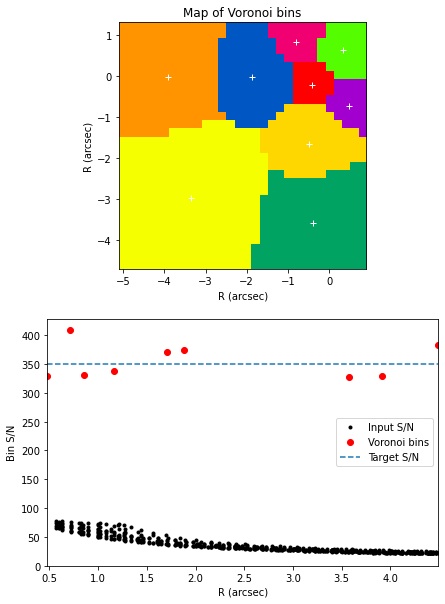

In [439]:
plt.figure(figsize=(7,10))
bin_num, x_gen, y_gen, xbin, ybin, sn, nPixels, scale = voronoi_2d_binning(s.x, s.y, signal, noise, target_sn, plot=1, quiet=1)

## Setup stellar templates

The important formula below **defines** the relation between velocity, wavelength and redshift in ``pPXF`` (eq. 8 of [Cappellari 2017](https://ui.adsabs.harvard.edu/abs/2017MNRAS.466..798C))


$V\equiv c\Delta\ln\lambda = c\ln(1+z)$

In [440]:
velscale = C*np.diff(s.ln_lam_gal[:2])   # eq.(8) of Cappellari (2017)

In [441]:
ppxf_dir = path.dirname(path.realpath(ppxf_package.__file__))
pathname = ppxf_dir + '/miles_models/Eun1.30*.fits'
FWHM_gal = None   # set this to None to skip convolutiona
miles = lib.miles(pathname, velscale, FWHM_gal, norm_range=[5070, 5950])
stars_templates, ln_lam_temp = miles.templates, miles.ln_lam_temp

The stellar templates are reshaped into a 2-dim array with each spectrum as a column, however we save the original array dimensions, which are needed to specify the regularization dimensions


In [442]:
reg_dim = stars_templates.shape[1:]
stars_templates = stars_templates.reshape(stars_templates.shape[0], -1)

See the pPXF documentation for the keyword REGUL, for an explanation of the following two lines.


In [443]:
stars_templates /= np.median(stars_templates) # Normalizes stellar templates by a scalar
regul_err = 0.01 # Desired regularization error

In [444]:
z = 0.002895  # redshift estimate from NED
vel0 = C*np.log(1 + z)  # Initial estimate of the galaxy velocity in km/s. eq. (8) of Cappellari (2017)
start = [vel0, 200.]  # (km/s), starting guess for [V,sigma]

In [445]:
lam_range_temp = np.exp(ln_lam_temp[[0, -1]])
goodpixels0 = util.determine_goodpixels(s.ln_lam_gal, lam_range_temp, z, width=1000)

## Fit templates and stellar kinematics in Voronoi binned data

In [446]:
nbins = sn.size
velbin, sigbin, lg_age_bin, metalbin, nspax = np.zeros((5, nbins))
optimal_templates = np.empty((stars_templates.shape[0], nbins))

##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       855       108
chi2/DOF: 1.238e+07; DOF: 2347; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
 Best Fit:       Vel     sigma
 comp.  0:       854       112
chi2/DOF: 2.591e+06; DOF: 2192; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 46; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
Weighted <lg_age> [yr]: 9.34
Weighted <[M/H]>: -0.136
Voronoi bin: 1 / 9
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       929       108
chi2/DOF: 5.324e+06; DOF: 2347; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 52; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:       935       112
chi2/DOF: 1.595e+06; DOF: 2260; degre

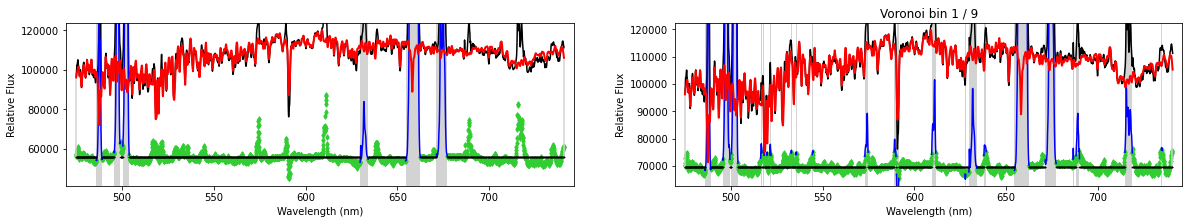

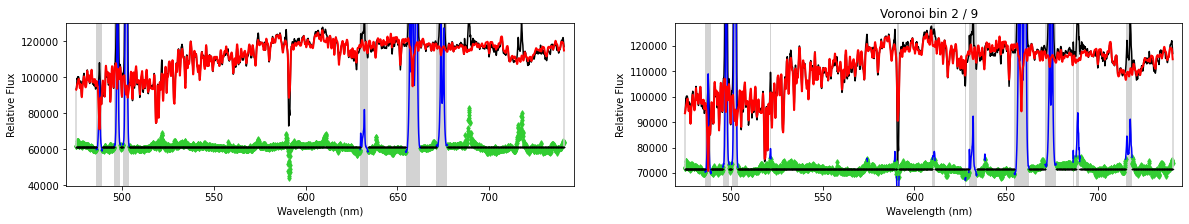

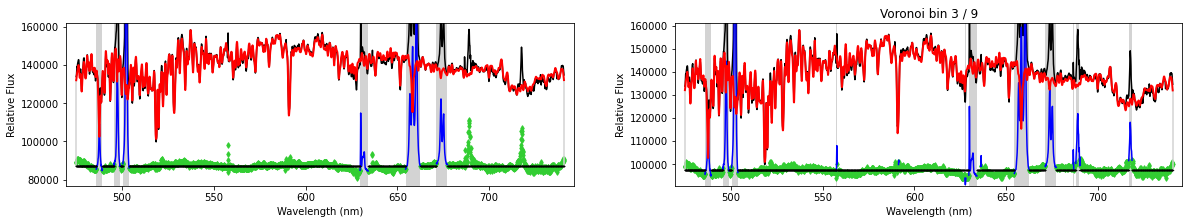

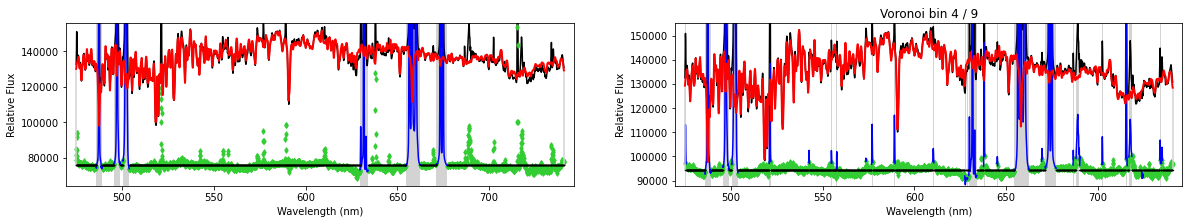

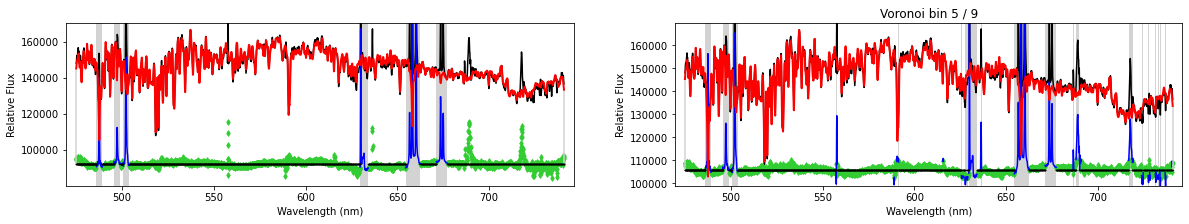

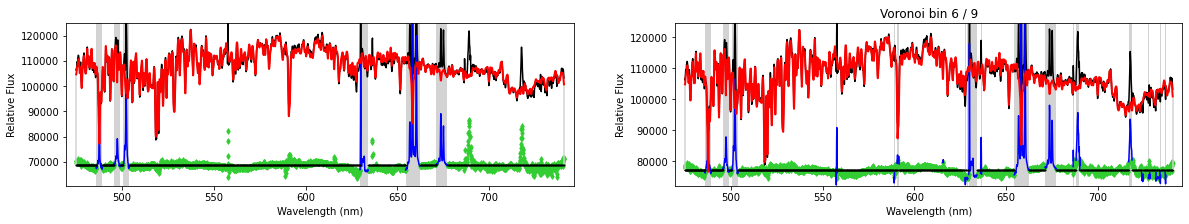

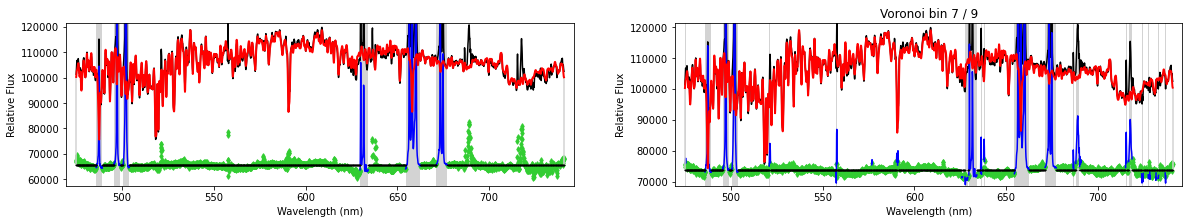

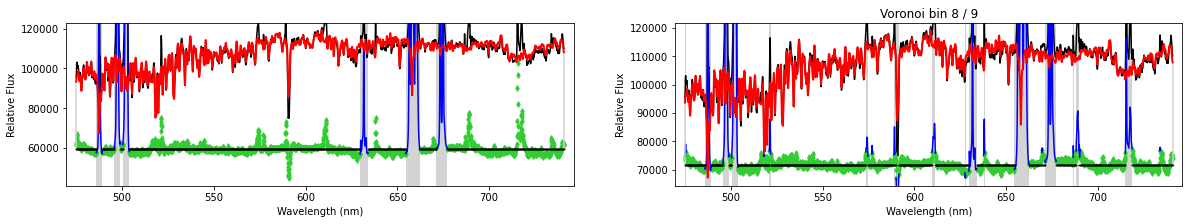

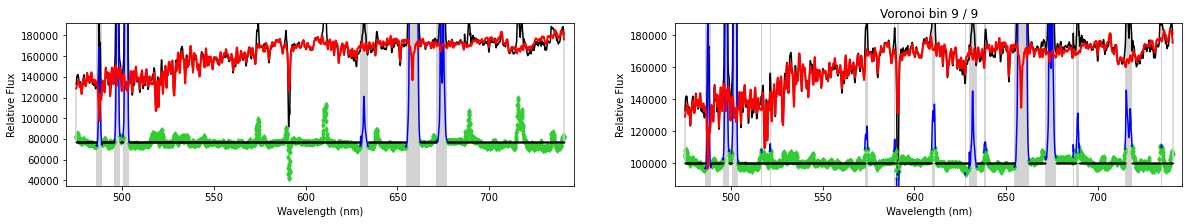

In [447]:
lam_gal = np.exp(s.ln_lam_gal)
for j in range(nbins):
    w = bin_num == j
    galaxy = np.sum(s.spectra[:, w], 1)
    pp, bestfit_template = fit_and_clean(stars_templates, galaxy, velscale, start, goodpixels0, lam_gal, miles.lam_temp)
    velbin[j], sigbin[j] = pp.sol
    optimal_templates[:, j] = bestfit_template

    light_weights = pp.weights.reshape(reg_dim)
    lg_age_bin[j], metalbin[j] = miles.mean_age_metal(light_weights)

    print(f'Voronoi bin: {j + 1} / {nbins}')
    plt.title(f"Voronoi bin {j + 1} / {nbins}")

Plot a map of the stellar velocity and lgAge in the Voronoi binned data.
This is the nearest neighbour interpolation.

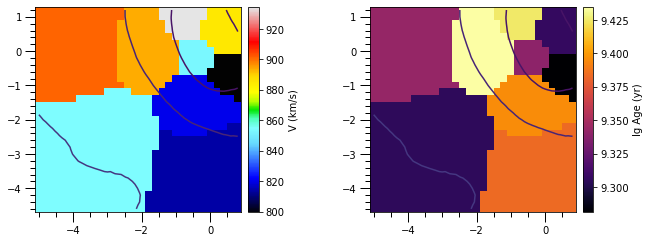

In [448]:
plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.5)

plt.subplot(121)
display_bins(s.x, s.y, bin_num, velbin, colorbar=1, label='V (km/s)')
plt.tricontour(s.x, s.y, -2.5*np.log10(signal/np.max(signal).ravel()), levels=np.arange(20));  # 1 mag contours

plt.subplot(122)
display_bins(s.x, s.y, bin_num, lg_age_bin, colorbar=1, cmap='inferno', label='lg Age (yr)')
plt.tricontour(s.x, s.y, -2.5*np.log10(signal/np.max(signal).ravel()), levels=np.arange(20));  # 1 mag contours

This is the linear interpolated version.

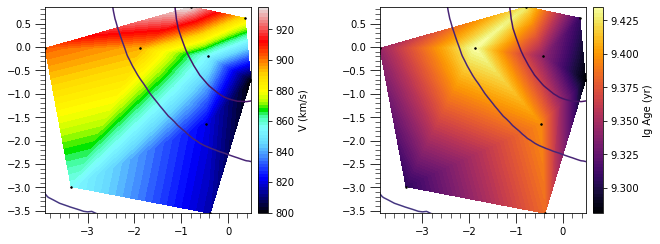

In [449]:
plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.5)

plt.subplot(121)
plot_velfield(xbin, ybin, velbin, colorbar=1, label='V (km/s)')
plt.tricontour(s.x, s.y, -2.5*np.log10(signal/np.max(signal).ravel()), levels=np.arange(20));  # 1 mag contours

plt.subplot(122)
plot_velfield(xbin, ybin, lg_age_bin, colorbar=1, cmap='inferno', label='lg Age (yr)')
plt.tricontour(s.x, s.y, -2.5*np.log10(signal/np.max(signal).ravel()), levels=np.arange(20));  # 1 mag contours

## Setup the gas emission line templates

Construct a set of Gaussian emission line templates. They have the width of the instrumental LSF.


In [450]:
lam_range_gal = [np.min(lam_gal), np.max(lam_gal)]
gas_templates, gas_names, line_wave = util.emission_lines(ln_lam_temp, lam_range_gal, s.fwhm_gal)

Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d'
 '[NII]6583_d']


Create three sets of gas templates for each of the 7 emission lines which fall within the fitted wavelength range.

In [451]:
ngas_comp = 3    # I use three gas kinematic components
gas_templates = np.tile(gas_templates, ngas_comp)
gas_names = np.asarray([a + f"_({p+1})" for p in range(ngas_comp) for a in gas_names])
line_wave = np.tile(line_wave, ngas_comp)

Here I select a single spaxel for this example. However, in a real analysys this would be replaced by a foor loop over every spaxel

In [452]:
j = 611  # clear double
j = 682  # near nucleus

In [453]:
galaxy = s.spectra[:, j]
noise = np.ones_like(galaxy)

Use as galaxy template the one determined at higher-S/N from the bin containing the current spaxel. I also keep the stellar kinematic fixed to the value determined from that bin.

In [454]:
k = bin_num[j]
template = optimal_templates[:, k]

Fit global template and only gas emission

In [455]:
stars_gas_templates = np.column_stack([template, gas_templates])
component = [0]  # Single stellar kinematic component=0

## Setup of pPXF input parameters

I fit the following 7 gas lines 

H$\beta$, H$\alpha$, [SII]6716, [SII]6731, [OIII]5007d, [OI]6300d, [NII]6583d

I divide the narrow lines into two kinematic `component=1` and `component=2`. I also include a broad kinematic `component=3`.

In [456]:
component += [1]*7
component += [2]*7
component += [3]*7
component = np.asarray(component)

I do not fit the stellar kinematics (I set negative `moments=-2`) but use instead the previously fitted solution for the bin that include the spaxel under analysys. I fit two `moments=2` (V, sigma) for all three gas components

In [457]:
moments = [-2, 2, 2, 2]

In [458]:
# start = [[V1, sig1], [V2, sig2], [V3, sig3], [V4, sig4]]
ncomp = len(moments)
tied = [['', ''] for j in range(ncomp)]
tied[2][1] = 'p[3]'                 # sig3 = sig2
tied[3][0] = '(p[2] + p[4])/2'      # V4 = (V2 + V3)/2

In [459]:
sig_diff = 200  # minimum dispersion difference in km/s
A_ineq = np.array([[0, 0, 0, 1, 0, 0, 0, -1],       # sigma2 - sigma4 < -sigma_diff
                   [0, 0, 0, 0, 0, 1, 0, -1]])      # sigma3 - sigma4 < -sigma_diff
b_ineq = np.array([-sig_diff, -sig_diff])/velscale  # in pixels
constr_kinem = {"A_ineq": A_ineq, "b_ineq": b_ineq}

In [460]:
start = [[velbin[k], sigbin[k]],
         [velbin[k], 50],
         [velbin[k], 50],
         [velbin[k], 500]]  # starting guess must be feasible

In [461]:
vlim = lambda x: velbin[k] + x*np.array([-100, 100])
bounds = [[vlim(2), [20, 300]],
          [vlim(2), [20, 100]],
          [vlim(6), [20, 100]],
          [vlim(2), [20, 1000]]]

## pPXF fit of the gas emission lines

Given that this spectrum contains multiple kinematic components well separated in velocity, the $\chi^2$ necessarily contain multiple minima. For this reason, I set the keyword `global_search=1`. This keyword should be used *only* when the problem has obvious multiple minima, as it is much slower and completely unnecessary in normal situations.

In [462]:
#%matplotlib widget
#%matplotlib inline

differential_evolution step 1: f(x)= 7.04914e+07
differential_evolution step 2: f(x)= 7.04914e+07
differential_evolution step 3: f(x)= 7.04914e+07
differential_evolution step 4: f(x)= 3.51321e+07
differential_evolution step 5: f(x)= 3.51321e+07
differential_evolution step 6: f(x)= 3.51321e+07
differential_evolution step 7: f(x)= 3.51321e+07
differential_evolution step 8: f(x)= 3.51321e+07
differential_evolution step 9: f(x)= 2.98865e+07
differential_evolution step 10: f(x)= 2.97559e+07
differential_evolution step 11: f(x)= 2.87562e+07
differential_evolution step 12: f(x)= 2.87562e+07
differential_evolution step 13: f(x)= 2.87562e+07
differential_evolution step 14: f(x)= 2.85208e+07
differential_evolution step 15: f(x)= 2.83975e+07
differential_evolution step 16: f(x)= 2.77739e+07
differential_evolution step 17: f(x)= 2.77739e+07
differential_evolution step 18: f(x)= 2.77341e+07
 Best Fit:       Vel     sigma
 comp.  0:       854       112
 comp.  1:       804        82
 comp.  2:      

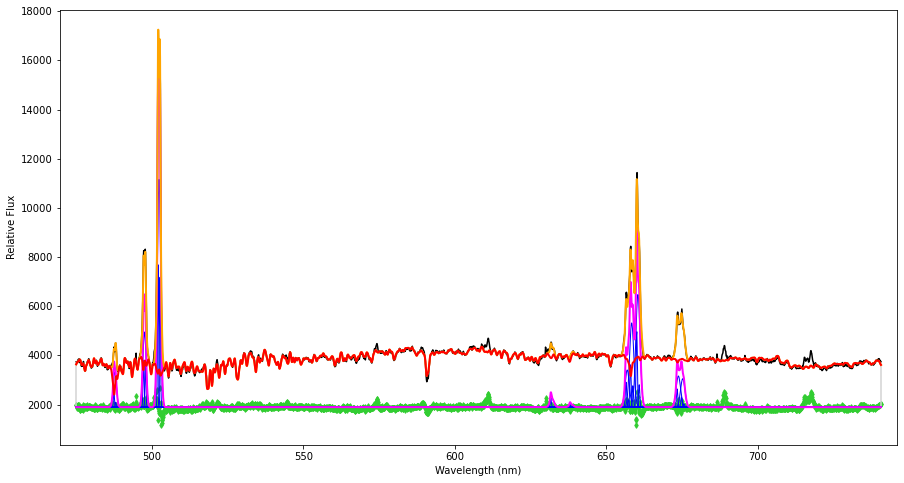

In [463]:
plt.figure(figsize=(15,8))
pp = ppxf(stars_gas_templates, galaxy, noise, velscale, start,
          plot=1, moments=moments, degree=8, mdegree=-1, component=component, 
          gas_component=component > 0, gas_names=gas_names, constr_kinem=constr_kinem, 
          lam=lam_gal, lam_temp=miles.lam_temp, tied=tied, bounds=bounds, global_search=True)

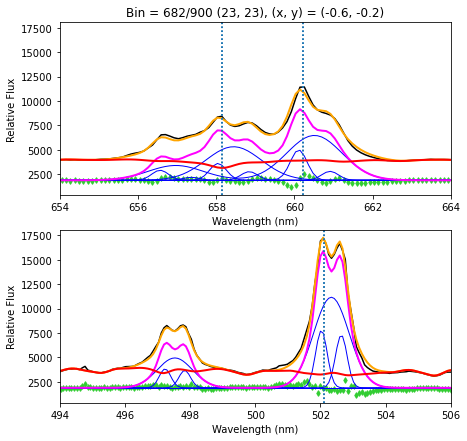

In [464]:
w = np.flatnonzero(np.char.find(gas_names, '(1)'))  # select first gas kinematic component
plt.figure(figsize=(7,7))

plt.subplot(211)
plt.title(f"Bin = {j}/{s.col.size} ({s.col[j]}, {s.row[j]}), (x, y) = ({s.x[j]:.1f}, {s.y[j]:.1f})")
pp.plot()
[plt.axvline(lam*np.exp(velbin[k]/C)/10, ls=':') for lam in line_wave[w]]
plt.xlim([654, 664])

plt.subplot(212)
pp.plot()
[plt.axvline(lam*np.exp(velbin[k]/C)/10, ls=':') for lam in line_wave[w]]
plt.xlim([494, 506]);


The `pPXF` documentation [HERE](https://pypi.org/project/ppxf/#output-parameters) states:

"IMPORTANT: ``pPXF`` makes no assumptions about the input flux units: The returned ``.gas_flux`` has the same units and values one would measure (with lower accuracy) by summing the pixels values, within the given gas lines, on the continuum-subtracted input galaxy spectrum. This implies that, if the spectrum is in units of ``erg/(s cm^2 A)``, the ``.gas_flux`` returned by ``pPXF`` should be multiplied by the pixel size in Angstrom at the line wavelength to obtain the integrated line flux in units of ``erg/(s cm^2)``."

For this reason, below I multiply the flux returned by `pPXF` by the pixel size at the wavelength of each line.


In [465]:
rms = robust_sigma(galaxy - pp.bestfit, zero=1)

names = ['Halpha', 'Hbeta' , '[NII]6583_d', '[OIII]5007_d']
for p, name in enumerate(names):
    kk = gas_names == name + '_(1)'   # Extract first gas kinematic component
    dlam = line_wave[kk]*velscale/C   # Angstrom per pixel at line wavelength (dlam/lam = dv/c)
    flux = (pp.gas_flux[kk]*dlam)[0]  # Convert to ergs/(cm^2 s)
    an = np.max(pp.gas_bestfit_templates[:, kk])/rms
    print(f"{name:12s} - Amplitude/Noise: {an:6.4g}; gas flux: {flux:6.0f} ergs/(cm^2 s)")

Halpha       - Amplitude/Noise:  24.78; gas flux:   9247 ergs/(cm^2 s)
Hbeta        - Amplitude/Noise:  8.464; gas flux:   2637 ergs/(cm^2 s)
[NII]6583_d  - Amplitude/Noise:  44.21; gas flux:  22221 ergs/(cm^2 s)
[OIII]5007_d - Amplitude/Noise:  83.49; gas flux:  34939 ergs/(cm^2 s)
